In [ ]:
!pip install obci_readmanager

     |████████████████████████████████| 61kB 3.0MB/s 
     |████████████████████████████████| 6.2MB 6.6MB/s 
  Created wheel for mne: filename=mne-0.17.2-cp37-none-any.whl size=6194609 sha256=a550d971b80e9002ebb04e4acb6922bb1881a279eb44b178473809a74da45c4b
  Stored in directory: /root/.cache/pip/wheels/e4/be/8b/6b737d272fb91d42e7ac5d61cc93227df7d71944e0e0eb15dd
Successfully built mne


In [ ]:
from obci_readmanager.signal_processing.read_manager import ReadManager as rm
import matplotlib.pyplot as plt
import numpy as np
import numpy.fft as fft
from scipy import signal
from obci_readmanager.signal_processing.smart_tags_manager import SmartTagsManager
from obci_readmanager.signal_processing.tags.smart_tag_definition import (
                    SmartTagDurationDefinition,
                    SmartTagEndTagDefinition)
import math
from math import floor, ceil

In [ ]:
xml = "/content/eog4.xml"
raw = "/content/eog4.raw"
tag = "/content/eog4.tag"
mgr = rm(xml,raw,tag)

sampling = float(mgr.get_param("sampling_frequency"))
num_of_channels = int(mgr.get_param("number_of_channels"))
channels_names = mgr.get_param("channels_names")

mgr_info = {
    'Sampling rate: ': sampling, 
    'Number of channels: ': num_of_channels,
    'Channels: ': channels_names
            }

for i in mgr_info:
  print(i+str(mgr_info[i]))

syg_raw = mgr.get_microvolt_samples()
T = len(syg_raw[0])/sampling
timeline = np.arange(0,T,1/sampling)
print(f'Signal duration: {T}s')

2021-06-13 10:07:31,885 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


Sampling rate: 2048.0
Number of channels: 3
Channels: ['poz', 'pion', 'TSS']
Signal duration: 116.0625s


In [ ]:
def get_signal_by_tag(syg, tag, end=0):
    # print(f'tag: {tag}')
    tag_start = tags[tag]['start']
    tag_end = tags[tag]['end']
    # print(f'tagi: {tag_start}, {tag_end}')
    sample_start = int(tag_start*sampling) 
    sample_end = int(tag_end*sampling)
    # print(f'sample: {sample_start}, {sample_end}, {sample_end - sample_start}')
    syg_temp = syg[sample_start:sample_end]
    timeline_temp = np.arange(0, (sample_end/sampling) - (sample_start/sampling), 1/sampling)
    if end == 0:
      end = (sample_end/sampling) - (sample_start/sampling)
    # else:
    #   syg_temp = syg
    #   timeline_temp = timeline
    # print(f'shape signal: {syg_temp.shape}')
    return syg_temp, timeline_temp, end

def plot(syg, title: str, tag=None, start=0, end=0):
  if type(syg) == list:
    #print('syg lista')
    length = 0
    if len(syg)%2 == 0:
      length = len(syg)/2
    else:
      length = len(syg)/2+1
    fig = plt.figure(figsize=(20,5))
    for numer, signal in enumerate(syg):
      ax = fig.add_subplot(2, length, numer+1)
      if type(tag) == str:
        syg_temp, timeline_temp, end = get_signal_by_tag(signal, tag, end)
        ax.title.set_text(''.join([tag[0].upper(),tag[1:]])+' '+str(title[numer]))
      else:
        syg_temp = syg
        ax.title.set_text(''.join([tag[0].upper(),tag[1:]])+' bez filtra')
      ax.plot(timeline_temp, syg_temp)
      ax.grid()
      # ax.xlabel('Czas [s]')
      # ax.ylabel('Napięcie [μV]')
      ax.set_xlim(start, end)
    fig.tight_layout()
    fig.show()
  else:
    if type(tag) == list:
      #print('tag lista')
      fig = plt.figure(figsize=(20,2.5))
      for numer, t in enumerate(tag):
        ax = fig.add_subplot(2,2,numer+1)
        syg_temp, timeline_temp, end = get_signal_by_tag(syg,t,end)
        ax.title.set_text(''.join([title[numer][0].upper(),title[numer][1:]])+' bez filtra')
        ax.plot(timeline_temp, syg_temp)
        ax.set_xlim(start, end)
        ax.grid()
      fig.tight_layout()
      fig.show()
    else:
      if type(tag) == str:
        syg_temp, timeline_temp, end = get_signal_by_tag(syg,tag,end)
      elif end == 0: 
        end = T
        syg_temp = syg
        timeline_temp = timeline
      else: 
        syg_temp = syg
        timeline_temp = timeline
      #print('podstawowa')
      if start !=0:
        timeline_temp = np.arange(start, end, 1/sampling)
        syg_temp = syg_temp[int(start*sampling):int(end*sampling)]
      plt.figure(figsize=(20,5))
      plt.plot(timeline_temp, syg_temp)
      plt.xlabel('Czas [s]')
      plt.ylabel('Napięcie [μV]')
      plt.xlim(start, end)
      plt.ylim(min(syg_temp),max(syg_temp))
      plt.yscale('linear')
      plt.title(title)
      plt.grid()
      plt.show()

def filtr(syg, typ, hz):
  b1, a1 = signal.butter(3, hz, btype=typ, fs=sampling)
  syg = signal.filtfilt(b1, a1, syg, axis=0)
  return syg

def tagTimestamps(tag):
  stamps = []
  for i in range(len(sig_tags)):
    if sig_tags[i]['name'] == tag:
      stamps.append((sig_tags[i-1]['start_timestamp'],sig_tags[i+1]['end_timestamp']))
  return stamps

def plotTags(tag): 
  fig = plt.figure(figsize=(20,5))
  temp_stamps = tagTimestamps(tag)
  for numer, signal in enumerate([vertical_hp_lp, horizontal_hp_lp]):
    ax = fig.add_subplot(1, 2, numer+1)
    for stamp in temp_stamps:
      sig_temp = signal[int(stamp[0]*sampling):int(stamp[1]*sampling)]
      ax.grid()
      try:
        timeline_temp = np.arange(0, (stamp[1]*sampling-stamp[0]*sampling-1)/sampling, 1/sampling)
        ax.grid()
        ax.plot(timeline_temp, sig_temp)
      except:
        timeline_temp = np.arange(0, stamp[1]-stamp[0], 1/sampling)
        ax.grid()
        ax.plot(timeline_temp, sig_temp)
      ax.grid()
      ax.title.set_text(titles[numer]+', tag: '+tag)
  fig.show()

In [ ]:
horizontal = syg_raw[0]
vertical = syg_raw[1]

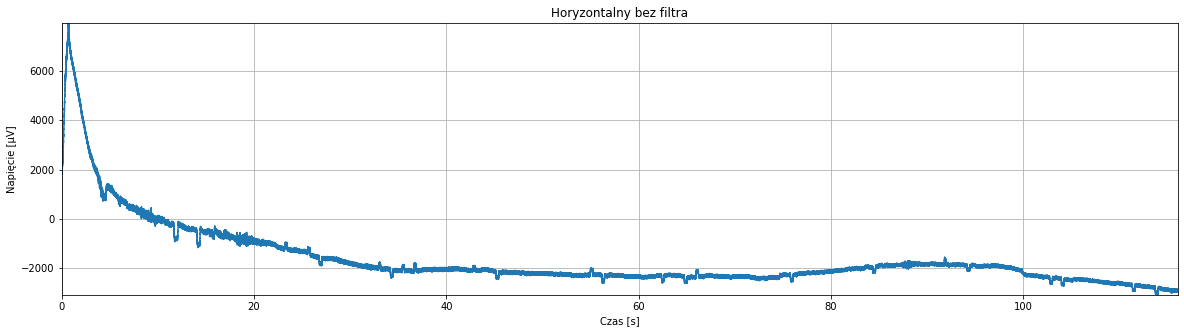

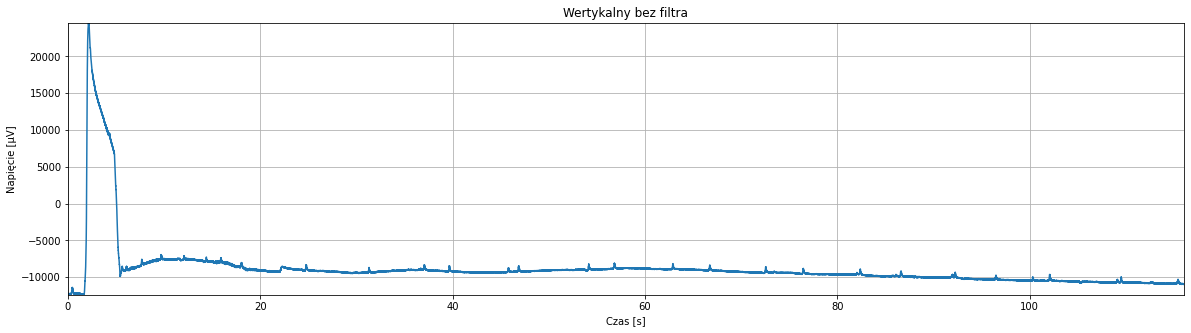

In [ ]:
plot(horizontal, 'Horyzontalny bez filtra')
plot(vertical, 'Wertykalny bez filtra')

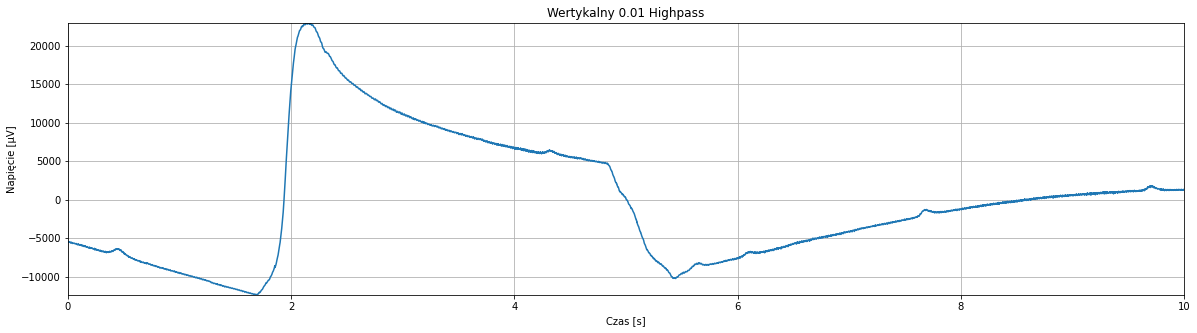

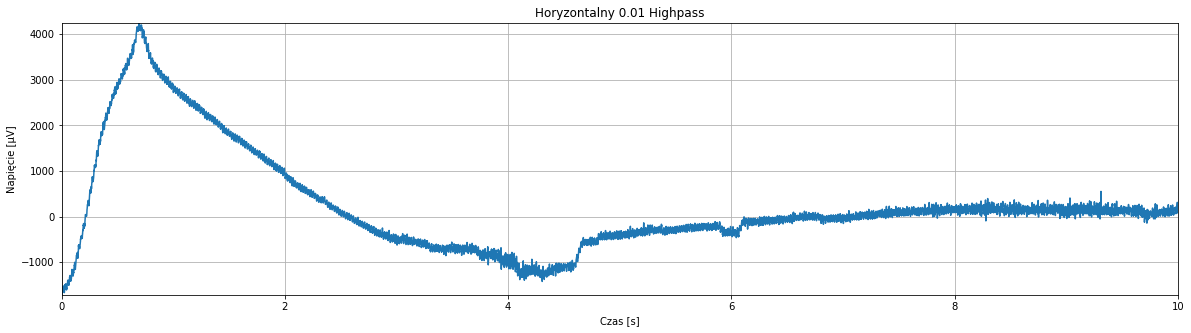

In [ ]:
vertical_hp = filtr(vertical, 'highpass', 0.1)
horizontal_hp = filtr(horizontal, 'highpass', 0.1)
plot(vertical_hp, 'Wertykalny 0.01 Highpass', end=10)
plot(horizontal_hp, 'Horyzontalny 0.01 Highpass', end=10)

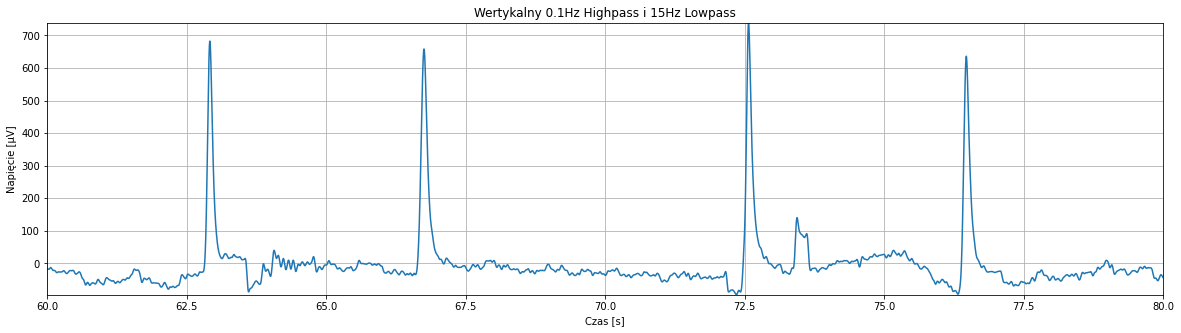

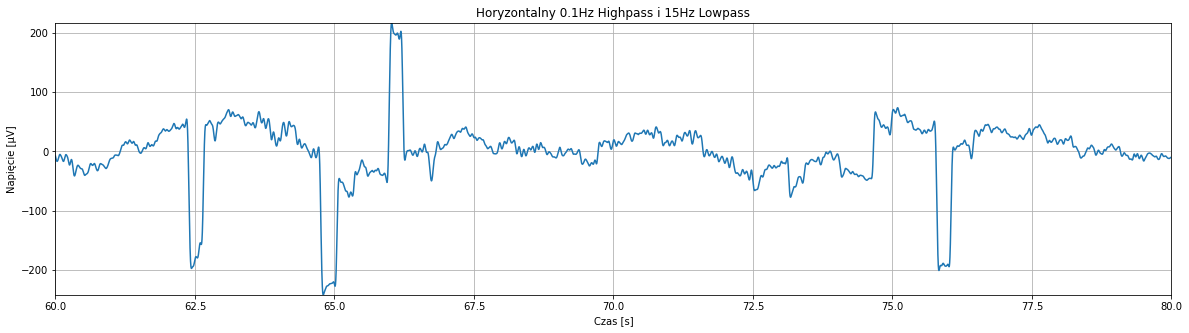

In [ ]:
vertical_hp_lp = filtr(vertical_hp, 'lowpass', 15)
horizontal_hp_lp = filtr(horizontal_hp, 'lowpass', 15)
plot(vertical_hp_lp, 'Wertykalny 0.1Hz Highpass i 15Hz Lowpass', end=80, start=60)
plot(horizontal_hp_lp, 'Horyzontalny 0.1Hz Highpass i 15Hz Lowpass', end=80, start=60)

In [ ]:
sig_tags = mgr.get_tags()

# Wizualizacja tagów dla danej nazwy i osi ruchu
Z jakiegoś dziwnego powodu dla pierwszego wykresu nie pojawia się plt.grid(), mimo użycia tej funkcji dosłownie w każdym możliwym miejscu plotTags

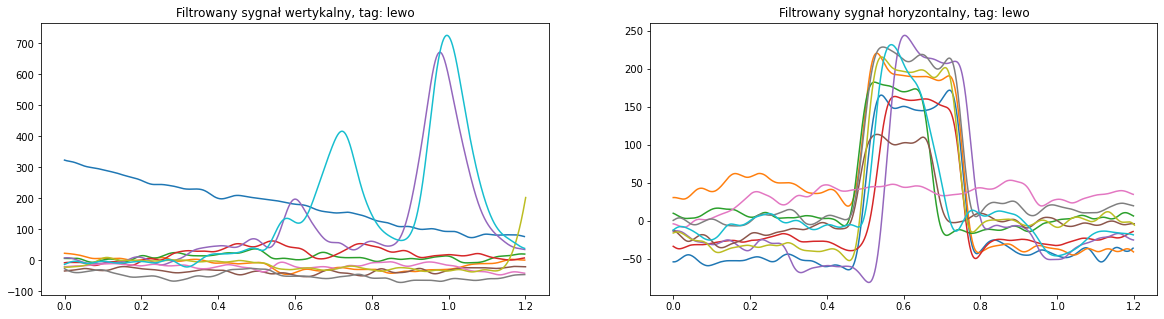

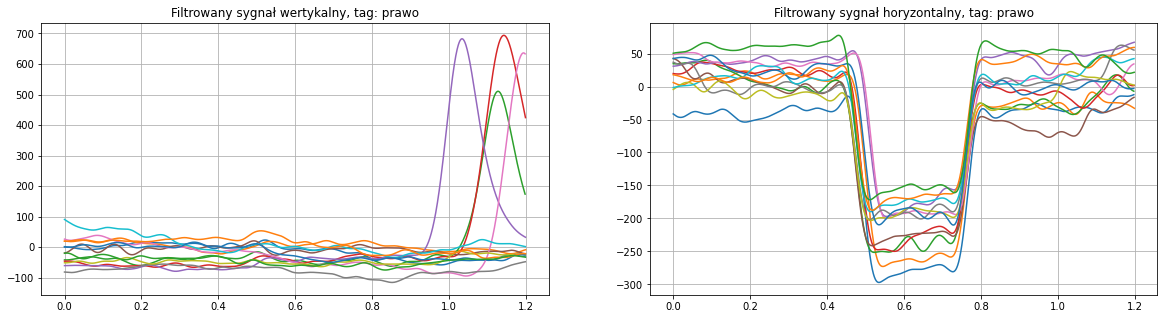

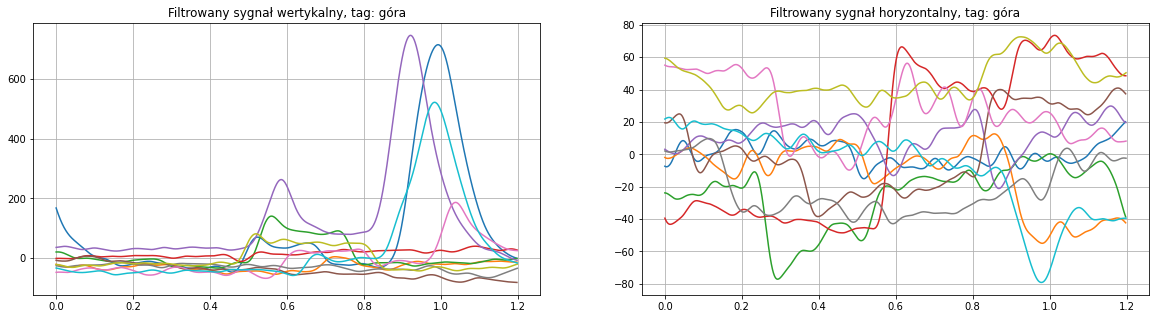

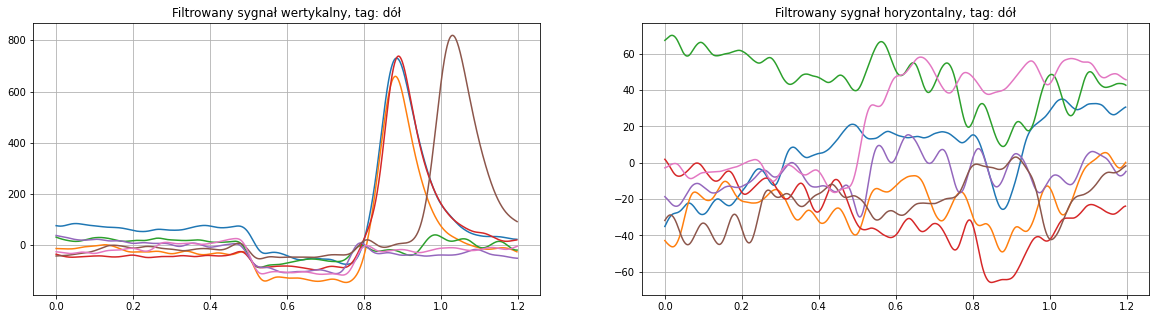

In [ ]:
tag_names = ['lewo','prawo','góra','dół']
titles = ['Filtrowany sygnał wertykalny', 'Filtrowany sygnał horyzontalny']

for i in tag_names:
  plotTags(i)

# Wierzchołki

**Przy pomocy peaków**  
Stworzenie histogramów z "surowych sygnałów", tj. bez konkretnych warunków pokaże, czego powinniśmy szukać podając warunki do find_peaks

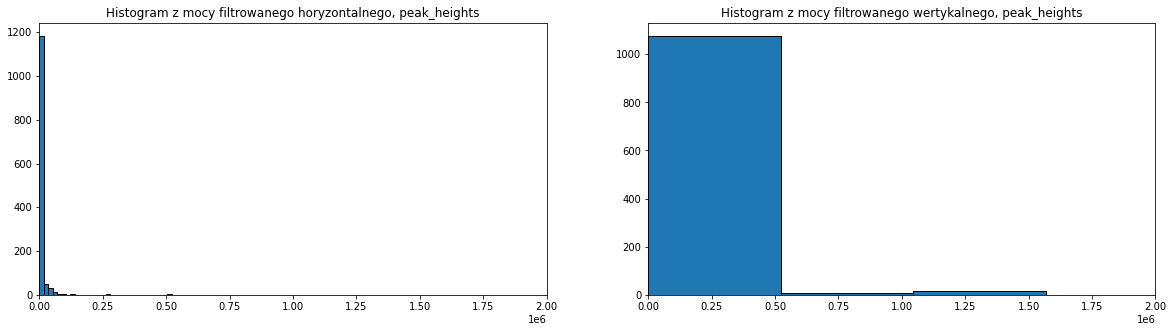

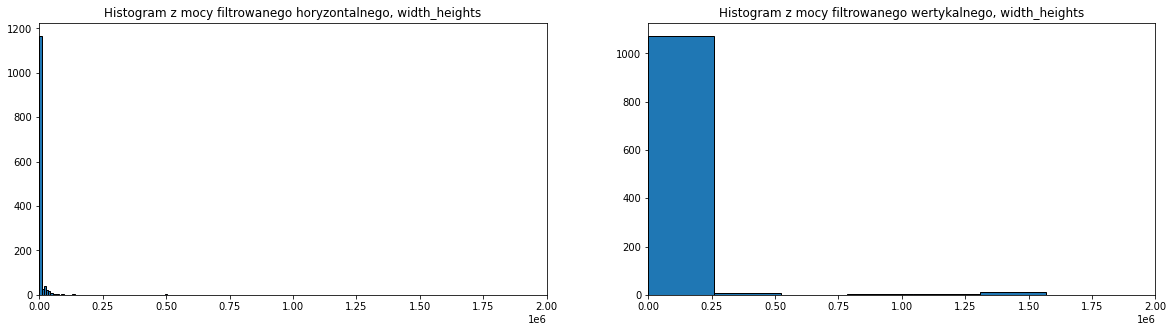

In [ ]:
hor_power = horizontal_hp_lp**2
ver_power = vertical_hp_lp**2
titles = ['Histogram z mocy filtrowanego horyzontalnego','Histogram z mocy filtrowanego wertykalnego']
properties = ['peak_heights','width_heights']

hor_peaks, hor_properties = signal.find_peaks(hor_power, height = 0, threshold = 0, distance = 1, prominence = (0.5, None), width = 0, plateau_size = 0)
ver_peaks, ver_properties = signal.find_peaks(ver_power, height = 0, threshold = 0, distance = 1, prominence = (0.5, None), width = 0, plateau_size = 0)

for j in properties:
  fig = plt.figure(figsize=(20,5))
  for numer, i in enumerate([hor_properties, ver_properties]):
    ax = fig.add_subplot(1,2,numer+1)
    ax.hist(i[j], bins=1000, edgecolor='black')
    ax.title.set_text(titles[numer]+', '+j)
    ax.set_xlim(0, 2e6)
  fig.show()

Mimo użycia histogramów distance został dobrany w sposób bardziej eksperymentalny, 0.25 nie dawało zadowalających rezultatów.

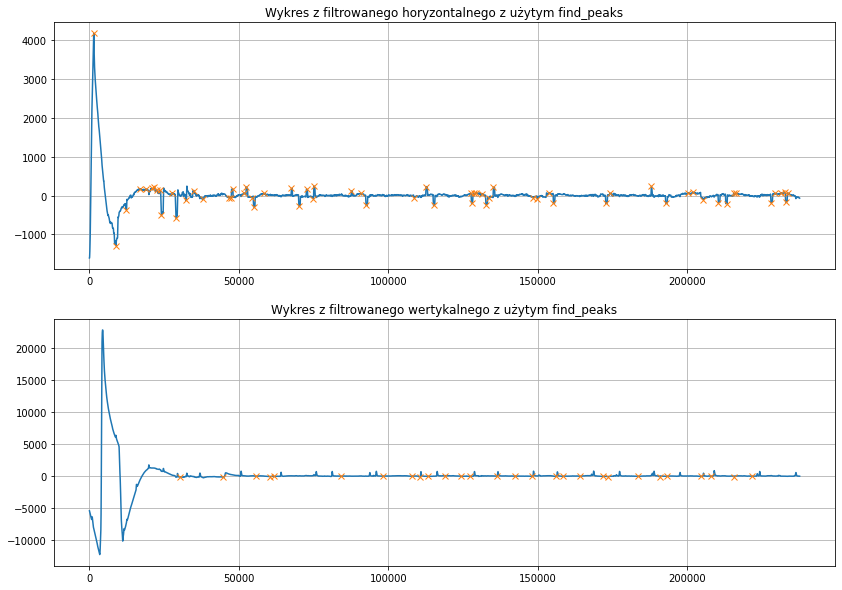

In [ ]:
hor_peaks, hor_properties = signal.find_peaks(hor_power, height = 2500, threshold = 0, distance = 1, prominence = (0.5, None), width = 0.11*sampling)
ver_peaks, ver_properties = signal.find_peaks(ver_power, height = (1000, 40000), threshold = 0, distance = 1, prominence = (0.5, None), width = 0.2*sampling)
titles = ['Wykres z filtrowanego horyzontalnego z użytym find_peaks', 'Wykres z filtrowanego wertykalnego z użytym find_peaks']

fig = plt.figure(figsize=(14,10))
for numer, i in enumerate([(horizontal_hp_lp,hor_peaks), (vertical_hp_lp,ver_peaks)]):
  ax = fig.add_subplot(2,1,numer+1)
  ax.plot(i[0])
  ax.grid()
  ax.plot(i[1], i[0][i[1]], "x")
  ax.title.set_text(titles[numer])
fig.show()

# Detektor
Oparty o wykroczenie poza 3 odchylenie standardowe oraz powrót do 1 odchylenia std i bardzo nieskomplikowany mechanizm pozwalający na przestanie doliczania tego samego wierzchołka po jego wykryciu - zmienna *analysis*

+ | Próbka: 47579, Czas wykrycia: 23.23193359375, wartość próbki: 163.1520172969578, wartość odchylenia: 162.78417680980354
  > Początek peaku: 47510, koniec peaku: 48032
+ | Próbka: 52428, Czas wykrycia: 25.599609375, wartość próbki: 164.53270510196378, wartość odchylenia: 162.78417680980354
  > Początek peaku: 52377, koniec peaku: 52950
- | Czas wykrycia: 26.78955078125, wartość próbki: -164.48560313672033, wartość odchylenia: -162.78417680980354
  > Początek peaku: 54824, koniec peaku: 55468
+ | Próbka: 67577, Czas wykrycia: 32.99658203125, wartość próbki: 163.706264710814, wartość odchylenia: 162.78417680980354
  > Początek peaku: 67519, koniec peaku: 67931
- | Czas wykrycia: 34.1982421875, wartość próbki: -164.67001901959588, wartość odchylenia: -162.78417680980354
  > Początek peaku: 69997, koniec peaku: 70606
+ | Próbka: 72628, Czas wykrycia: 35.462890625, wartość próbki: 162.7920577116624, wartość odchylenia: 162.78417680980354
  > Początek peaku: 72542, koniec peaku: 72998
+ |

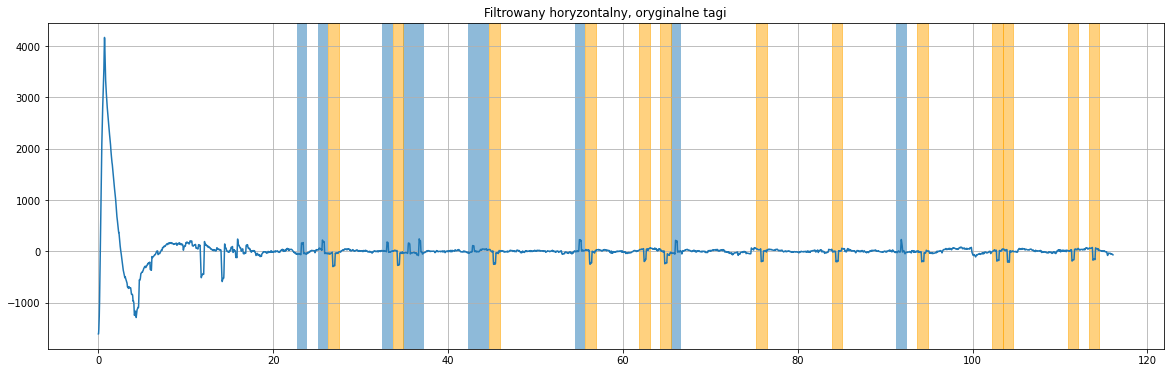

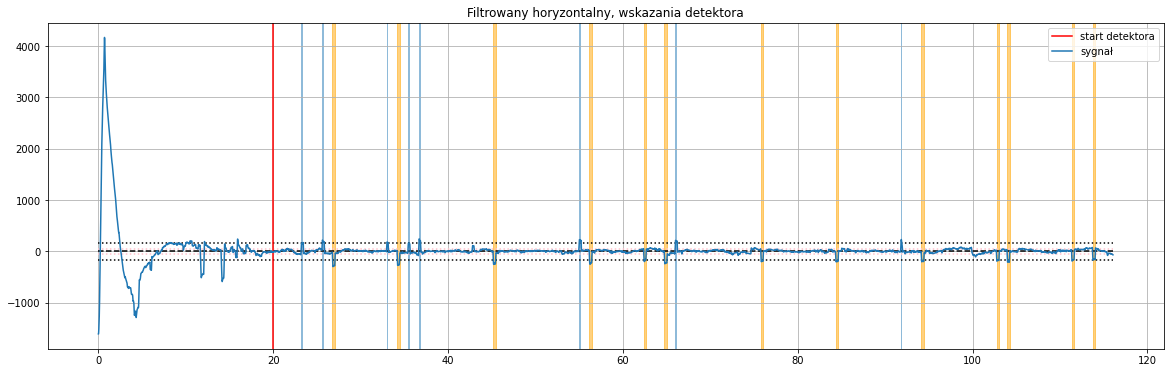

In [ ]:
hor = horizontal_hp_lp
hor_std = np.std(horizontal_hp_lp[int(20*sampling):])
hor_mean = np.mean(horizontal_hp_lp[int(20*sampling):])

stamps_left = tagTimestamps('lewo')
stamps_right = tagTimestamps('prawo')

peaks_left = []
peaks_right = []
analysis = False
found = ''
for i in range(int(20*sampling),len(hor)):
  if hor[i] >= 3*hor_std and analysis == False:
    hit = i
    analysis = True
    found = '+'
    print(f'+ | Próbka: {i}, Czas wykrycia: {i/sampling}, wartość próbki: {hor[i]}, wartość odchylenia: {3*hor_std}')
    index = i
    while hor[index] > hor_std:
      # print(str(index)+' '+str(hor[index]))
      index -= 1
    start = index
    index = i
    while hor[index] > hor_std:
      # print(str(index)+' '+str(hor[index]))
      index += 1
    end = index
    peaks_left.append((start,end,hit))
    print(f'  > Początek peaku: {start}, koniec peaku: {end}')
  elif hor[i] <= -3*hor_std and analysis == False:
    analysis = True
    hit = i
    found = '-'
    print(f'- | Czas wykrycia: {i/sampling}, wartość próbki: {hor[i]}, wartość odchylenia: {-3*hor_std}')
    index = i
    while hor[index] < -hor_std:
      index -= 1
    start = index
    index = i
    while hor[index] < -hor_std:
      index += 1
    end = index
    peaks_right.append((start,end,hit))
    print(f'  > Początek peaku: {start}, koniec peaku: {end}')
  elif found == '+' and hor[i]<0.5*hor_std:
    analysis = False
  elif found == '-' and hor[i]>-0.5*hor_std:
    analysis = False

plt.figure(figsize=(20,6))
for i in stamps_left:
  plt.axvspan(i[0],i[1],alpha=0.5)
for i in stamps_right:
  plt.axvspan(i[0],i[1],alpha=0.5, color='orange')  
plt.plot(timeline,hor)
plt.title('Filtrowany horyzontalny, oryginalne tagi')
plt.grid()
plt.show()

plt.figure(figsize=(20,6))
plt.axvline(20, color='red')
for i in peaks_left:
  plt.axvspan(i[0]/sampling,i[1]/sampling,alpha=0.5)
  # plt.axvline(i[2]/sampling, color='blue')
for i in peaks_right:
  plt.axvspan(i[0]/sampling,i[1]/sampling,alpha=0.5, color='orange')  
  # plt.axvline(i[2]/sampling, color='yellow')
plt.plot(timeline,hor)
plt.hlines(3*hor_std, 0, T, linestyles='dotted')
plt.hlines(hor_std, 0, T, linestyles='dotted', color='pink')
plt.hlines(-hor_std, 0, T, linestyles='dotted', color='pink')
plt.hlines(-3*hor_std, 0, T, linestyles='dotted')
plt.hlines(hor_mean, 0, T, linestyles='dashed')
plt.title('Filtrowany horyzontalny, wskazania detektora')
plt.legend(['start detektora', 'sygnał'])
# plt.xlim(90,110)
plt.grid()
plt.show()

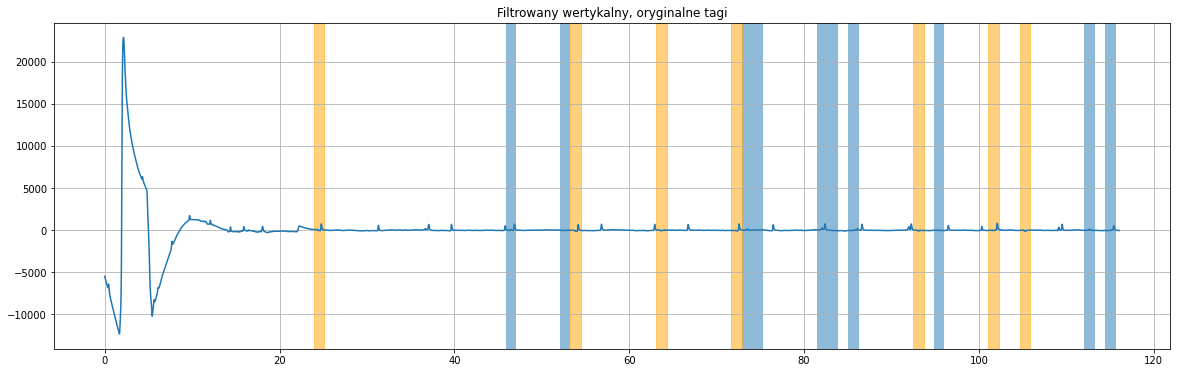

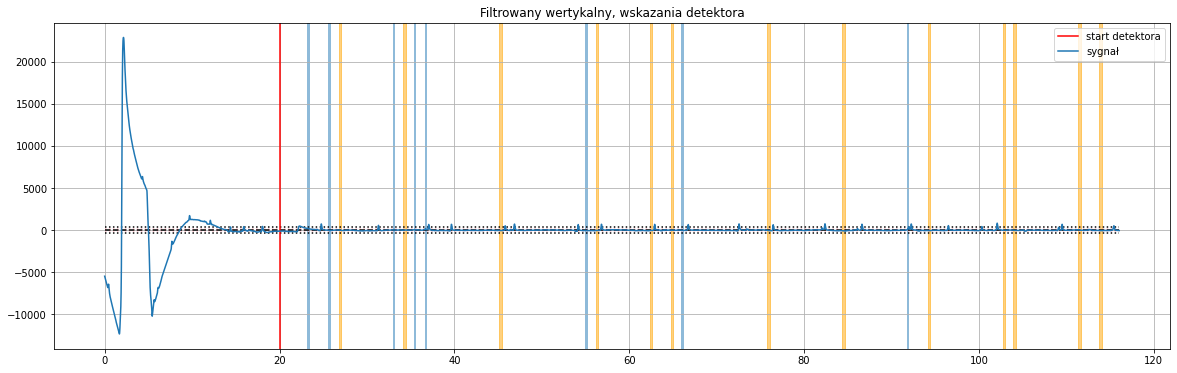

In [ ]:
ver = vertical_hp_lp
ver_std = np.std(vertical_hp_lp[int(20*sampling):])
ver_mean = np.mean(vertical_hp_lp[int(20*sampling):])

stamps_left = tagTimestamps('góra')
stamps_right = tagTimestamps('dół')

peaks_up = []
peaks_down = []
analysis = False
found = ''
for i in range(int(20*sampling),len(ver_peaks)):
  if ver[i] >= 3*ver_std and analysis == False:
    hit = i
    analysis = True
    found = '+'
    print(f'+ | Próbka: {i}, Czas wykrycia: {i/sampling}, wartość próbki: {ver[i]}, wartość odchylenia: {3*ver_std}')
    index = i
    while ver[index] > verstd:
      # print(str(index)+' '+str(hor[index]))
      index -= 1
    start = index
    index = i
    while ver[index] > ver_std:
      # print(str(index)+' '+str(hor[index]))
      index += 1
    end = index
    peaks_up.append((start,end,hit))
    print(f'  > Początek peaku: {start}, koniec peaku: {end}')
  elif ver[i] <= -3*ver_std and analysis == False:
    analysis = True
    hit = i
    found = '-'
    print(f'- | Czas wykrycia: {i/sampling}, wartość próbki: {ver[i]}, wartość odchylenia: {-3*ver_std}')
    index = i
    while ver[index] < -ver_std:
      index -= 1
    start = index
    index = i
    while ver[index] < -ver_std:
      index += 1
    end = index
    peaks_down.append((start,end,hit))
    print(f'  > Początek peaku: {start}, koniec peaku: {end}')
  elif found == '+' and ver[i]<0.5*ver_std:
    analysis = False
  elif found == '-' and ver[i]>-0.5*ver_std:
    analysis = False

plt.figure(figsize=(20,6))
for i in stamps_left:
  plt.axvspan(i[0],i[1],alpha=0.5)
for i in stamps_right:
  plt.axvspan(i[0],i[1],alpha=0.5, color='orange')  
plt.plot(timeline,ver)
plt.title('Filtrowany wertykalny, oryginalne tagi')
plt.grid()
plt.show()

plt.figure(figsize=(20,6))
plt.axvline(20, color='red')
for i in peaks_left:
  plt.axvspan(i[0]/sampling,i[1]/sampling,alpha=0.5)
  # plt.axvline(i[2]/sampling, color='blue')
for i in peaks_right:
  plt.axvspan(i[0]/sampling,i[1]/sampling,alpha=0.5, color='orange')  
  # plt.axvline(i[2]/sampling, color='yellow')
plt.plot(timeline,ver)
plt.hlines(3*ver_std, 0, T, linestyles='dotted')
plt.hlines(ver_std, 0, T, linestyles='dotted', color='pink')
plt.hlines(-ver_std, 0, T, linestyles='dotted', color='pink')
plt.hlines(-3*ver_std, 0, T, linestyles='dotted')
plt.hlines(ver_mean, 0, T, linestyles='dashed')
plt.title('Filtrowany wertykalny, wskazania detektora')
plt.legend(['start detektora', 'sygnał'])
# plt.xlim(90,110)
plt.grid()
plt.show()